(lecture15:polynomial-regression)=
# Polynomial Regression

We take up where we left in the previous section.
Recall that we tried to fit a linear regression model to data generated from:

$$
y_i = -0.5 + 2x_i + 2x_i^2 + \epsilon_i,
$$

where $\epsilon_i \sim N(0, 1)$ and where we sample $x_i \sim U([-1,1])$:

In [19]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

import numpy as np
import scipy.stats as st

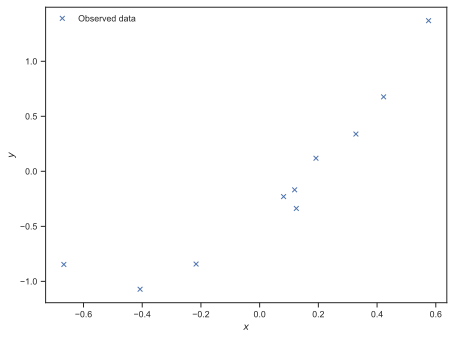

In [20]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = make_full_width_fig()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

We already saw that the linear model does not work here.
We need to try to fit a quadratic model:

$$
y = w_0 + w_1 x + w_2 x^2.
$$

How can we do this? Of course, by minimizing the square loss:

$$
L(w_0, w_1, w_2) = \sum_{i=1}^N(y_i - w_0 - w_1 x_i - w_2 x_i^2)^2.
$$

Fortunately, we do not have to do things from scratch.
The notation we developed previously comes to our resque.
Recall, that $\mathbf{y} = (y_1,\dots,y_N)$ is the vector of observations.
Use

$$
\mathbf{w} = (w_0, w_1, w_2),
$$ 

to denote the weight vector.
What about the design matrix?
Before it was an $N\times 2$ matrix with the first column being one and the second column being the vector of observed inputs.
Well, now it is the $N\times 3$ matrix.
The first two columns are exactly like before, but now the third column is the observed inputs squared.
So, it is:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 & x_1^2\\
1 & x_2 & x_2^2\\
\vdots & \vdots \\
1 & x_N & x_N^2
\end{bmatrix}.
$$

As before, if you multiply the design matrix $\mathbf{X}$ with the weight vector $\mathbf{w}$ you get the predictions of our model.
So, again, the square loss can be written as:

$$
L(w_0, w_1, w_2) = L(\mathbf{w}) = \parallel \mathbf{y} - \mathbf{X}\mathbf{w}\parallel^2.
$$

Well, this is mathematically the same equation as before.
The only difference is that we have 3-dimensional weight vector (instead of a 2-dimensional) and that the design matrix is $N\times 3$ instead of $N\times 2$.
If you take the gradien of this with respect to $\mathbf{w}$ and set it equal to zero you will get that you need to solve exactly the same linear system of equations as before (but now it is 3 equations for 3 unknowns instead of 2 equations for 2 unknowns).

Let's solve it numerically.
First, the design matrix:

In [21]:
X = np.hstack([np.ones((num_obs, 1)), x.reshape((num_obs, 1)), x.reshape((num_obs, 1)) ** 2])
X

array([[ 1.        ,  0.12495019,  0.01561255],
       [ 1.        , -0.66699115,  0.44487719],
       [ 1.        ,  0.19184789,  0.03680561],
       [ 1.        ,  0.42223319,  0.17828086],
       [ 1.        ,  0.08155814,  0.00665173],
       [ 1.        ,  0.32792162,  0.10753259],
       [ 1.        , -0.21652599,  0.0468835 ],
       [ 1.        ,  0.57542569,  0.33111473],
       [ 1.        , -0.40728776,  0.16588332],
       [ 1.        ,  0.11915886,  0.01419883]])

and then:

In [22]:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f'w_0 = {w[0]:1.2f}')
print(f'w_1 = {w[1]:1.2f}')
print(f'w_2 = {w[2]:1.2f}')

w_0 = -0.49
w_1 = 2.01
w_2 = 2.09


Let's visualize the model predictions:

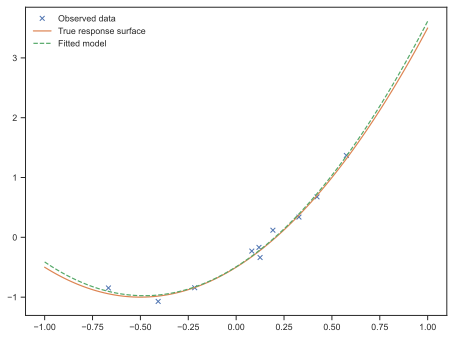

In [23]:
fig, ax = make_full_width_fig()
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# The model we just fitted
yy = w[0] + w[1] * xx + w[2] * xx ** 2
# plot the data again
ax.plot(x, y, 'x', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
# overlay our prediction
ax.plot(xx, yy, '--', label='Fitted model')
plt.legend(loc='best')
save_for_book(fig, 'ch15.fig3')

## Questions

+ Repeat with very small ``num_obs`` and very large ``num_obs`` and observe the behavior of the fit.

## Regression with high-degree polynomials and overfitting

What would have happened if we tried to use a higher degree polynomial.
To achieve this, we need to be able to evaluate a design matrix of the form:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 & x_1^2\dots & x_1^\rho\\
1 & x_2 & x_2^2\dots & x_2^\rho\\
\vdots & \vdots\dots & \vdots\\
1 & x_N & x_N^2 \dots & x_N^\rho
\end{bmatrix},
$$

where $\rho$ is the degree of the polynomial.
The linear system we need to solve is the same as before.
Only the weight vector is now $\rho + 1$ dimensional and the design matrix $N\times (\rho + 1)$.

Let's write some code to find the design matrix.

In [24]:
def get_polynomial_design_matrix(x, degree):
    """Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

Let's try fitting a degree 3 polynomial and see what we get:

In [25]:
degree = 3
# The design matrix is:
X = get_polynomial_design_matrix(x[:, None], degree)
# And we fit just like previously:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print('w = ', w)

w =  [-0.49917178  2.17872524  2.04756027 -0.58403532]


Let's visualize the fit.
Notice, that for making predictions I am evaluating the design matrix on the points I want to make predictions at.

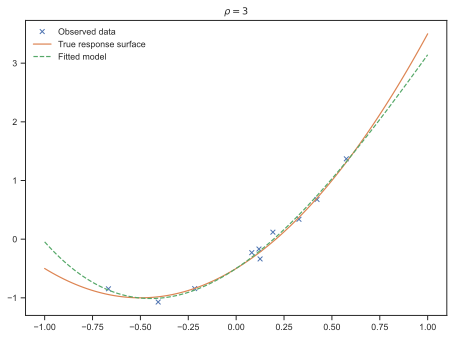

In [26]:
fig, ax = make_full_width_fig()
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# The model we just fitted
XX = get_polynomial_design_matrix(xx[:, None], degree)
yy = np.dot(XX, w)
# plot the data again
ax.plot(x, y, 'x', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
# overlay our prediction
ax.plot(xx, yy, '--', label='Fitted model')
ax.set_title(r'$\rho = {0:d}$'.format(degree))
plt.legend(loc='best')
save_for_book(fig, 'ch15.fig4')

## Questions

+ Start increasing the polynomial degree from 3, to 4, to a number where things get bad... You will soon start *overfitting*.